In [9]:
using DiffEqJump, StochasticDiffEq, DiffEqCallbacks
using StatsBase, Parameters, Plots, Distributions

In [10]:
# invariant parameters 
function drift(du,u,p,t) # constant drift
      du .= p.μ
end
function volatility(du,u,p,t) # constant shock exposure
      du .= p.σ
end

# main params bundle
params = @with_kw (
    μ = 0.01, # mean
    σ = 0.1, # drift
    N = 30, # num particles
    β = 0.2, # rate parameter
    t = 0.:0.01:10., # time steps to save
    moments = Array{Array{Float64, 1}, 1}(), # container for moments
    α = 2.0, # shape parameter for the initial condition distribution
    iv_dist = Exponential(1/α), # updates based on supplied α
    trajectories = 2, # number of members for ensemble methods 
    jump_algorithm = SRIW1(), # jump diffeq algorithm
    drift = drift, 
    volatility = volatility,
    ρ_max = 2.0)

#14 (generic function with 2 methods)

In [11]:
# generator functions
function generate_jump_prob(p, rate_index, affect_index!)
    x_iv = rand(p.iv_dist, p.N) # draw initial condition
    sde_prob = SDEProblem(p.drift, p.volatility, x_iv, (0.0, p.t[end]), p)
    jumps = [VariableRateJump((u, p, t) -> rate_index(u, p, t, i), (integrator) -> affect_index!(integrator, i)) for i in 1:p.N];
    jump_prob = JumpProblem(sde_prob, DirectFW(), JumpSet((jumps),(),nothing,nothing))
    return jump_prob
end

function generate_ensemble_prob(jump_prob)
    function write_moments(sol, i)
        newsol = DiffEqBase.build_solution(sol.prob, sol.alg, sol.prob.p.t, sol.prob.p.moments)
        return newsol, false
    end
    function calculate_moments(u, t, integrator) 
        g = (length(integrator.p.moments) == 0. ? 0. : (mean(u) - integrator.p.moments[end][2])/step(integrator.p.t))
        moments = [minimum(u), mean(u), maximum(u), g]
        push!(integrator.p.moments, moments) 
    end
    cb = FunctionCallingCallback(calculate_moments; funcat=p.t, func_everystep=false, func_start = true, tdir=1);
    ensemble_prob = EnsembleProblem(jump_prob, output_func = write_moments)    
    return ensemble_prob, cb
end

generate_ensemble_prob (generic function with 1 method)

### Default (Broken) Output

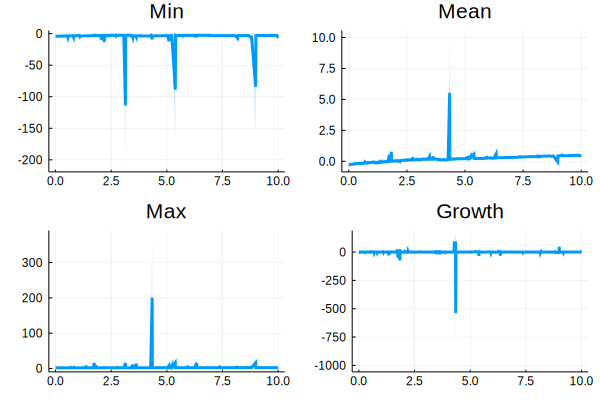

In [12]:
function rate_index(u, p, t, index)
   u_max = maximum(u)
   u_min = minimum(u)
   return p.ρ_max* ((u[index] - u_max)^2 / (u_max - u_min))
end
affect_index!(integrator, index) = (integrator.u[index] = max(integrator.u[index], integrator.u[rand(1:integrator.p.N)]))

p = params()
jump_prob = generate_jump_prob(p, rate_index, affect_index!)
ensemble_prob, cb = generate_ensemble_prob(jump_prob)

sim = solve(ensemble_prob, p.jump_algorithm, EnsembleDistributed(), trajectories = p.trajectories, callback = cb, save_everystep = false)
summ = EnsembleSummary(sim)
p1 = plot(summ, idxs = [1], title = "Min")
p2 = plot(summ, idxs = [2], title = "Mean")
p3 = plot(summ, idxs = [3], title = "Max")
p4 = plot(summ, idxs = [4], title = "Growth")
plot(p1, p2, p3, p4)

### New Algorithm

In [ ]:
p = params(jump_algorithm = SOSRI())
jump_prob = generate_jump_prob(p, rate_index, affect_index!)
ensemble_prob, cb = generate_ensemble_prob(jump_prob)

sim = solve(ensemble_prob, p.jump_algorithm, EnsembleDistributed(), trajectories = p.trajectories, callback = cb, save_everystep = false)
summ = EnsembleSummary(sim)
p1 = plot(summ, idxs = [1], title = "Min")
p2 = plot(summ, idxs = [2], title = "Mean")
p3 = plot(summ, idxs = [3], title = "Max")
p4 = plot(summ, idxs = [4], title = "Growth")
plot(p1, p2, p3, p4)

### No Affect

In [ ]:
affect_index!(integrator, index) = nothing

p = params()
jump_prob = generate_jump_prob(p, rate_index, affect_index!)
ensemble_prob, cb = generate_ensemble_prob(jump_prob)

sim = solve(ensemble_prob, p.jump_algorithm, EnsembleDistributed(), trajectories = p.trajectories, callback = cb, save_everystep = false)
summ = EnsembleSummary(sim)
p1 = plot(summ, idxs = [1], title = "Min")
p2 = plot(summ, idxs = [2], title = "Mean")
p3 = plot(summ, idxs = [3], title = "Max")
p4 = plot(summ, idxs = [4], title = "Growth")
plot(p1, p2, p3, p4)

### No Variable Rate

In [ ]:
rate_index(u, p, t, i) = 2 # constant across indices, times, etc.
affect_index!(integrator, index) = (integrator.u[index] = max(integrator.u[index], integrator.u[rand(1:integrator.p.N)])) # original 

p = params()
jump_prob = generate_jump_prob(p, rate_index, affect_index!)
ensemble_prob, cb = generate_ensemble_prob(jump_prob)

sim = solve(ensemble_prob, p.jump_algorithm, EnsembleDistributed(), trajectories = p.trajectories, callback = cb, save_everystep = false)
summ = EnsembleSummary(sim)
p1 = plot(summ, idxs = [1], title = "Min")
p2 = plot(summ, idxs = [2], title = "Mean")
p3 = plot(summ, idxs = [3], title = "Max")
p4 = plot(summ, idxs = [4], title = "Growth")
plot(p1, p2, p3, p4)

### Neither Affect nor Variable Rate

In [ ]:
rate_index(u, p, t, i) = 0.2 # constant across indices, times, etc.
affect_index!(integrator, index) = nothing

p = params()
jump_prob = generate_jump_prob(p, rate_index, affect_index!)
ensemble_prob, cb = generate_ensemble_prob(jump_prob)

sim = solve(ensemble_prob, p.jump_algorithm, EnsembleDistributed(), trajectories = p.trajectories, callback = cb, save_everystep = false)
summ = EnsembleSummary(sim)
p1 = plot(summ, idxs = [1], title = "Min")
p2 = plot(summ, idxs = [2], title = "Mean")
p3 = plot(summ, idxs = [3], title = "Max")
p4 = plot(summ, idxs = [4], title = "Growth")
plot(p1, p2, p3, p4)